The correct order is:  

1. **Missing values imputation** → Handle missing data first to avoid issues in later steps.  
2. **Outlier removal** → Remove extreme values after imputation, as missing value treatment might introduce new outliers.  
3. **Feature transformation** → Apply transformations like scaling, log transformation,assigning weightages etc., to standardize or normalize data.  
4. **Feature encoding** → Convert categorical variables into numerical format for model compatibility.  (One-Hot Encoding, Label Encoding, etc.) 
5. **Feature extraction** → Derive new features from existing ones (e.g., PCA, text embeddings).  
6. **Feature selection** → Remove irrelevant or redundant features to improve model performance.  

# User-Defined Functions

about data : value_counts and unique categories 

In [11]:
def analyze_value_counts(df, feature, top_n=None):
    print(f"Unique Categories in '{feature}': {df[feature].nunique()}")
    print("-" * 50)

    if top_n is not None:
        print(df[feature].value_counts().head(top_n))
    else:
        print(df[feature].value_counts())

Function to analyze missing values and summary statistics of a given column

In [12]:
def analyze_column(df, feature):
    print(f"Missing Values in '{feature}': {df[feature].isnull().sum()}")
    print("-" * 50)

    if df[feature].dtype in ["float64", "int64"]:  # Numerical columns
        print(df[feature].describe())
    elif df[feature].dtype in ["object","category"]:  # Categorical columns
        print(df[feature].value_counts())

Function to visualize the distribution of a numerical feature using Histogram, QQ Plot, and Box Plot

In [13]:
def num_three_chart_plot(df, feature):
    fig = plt.figure(constrained_layout=True, figsize=(20, 8))
    grid = gridspec.GridSpec(ncols=4, nrows=6, figure=fig)

    ax1 = fig.add_subplot(grid[0:3, :3])  # Increase histogram height
    ax1.set_title('Histogram')
    sns.histplot(df[feature], kde=True, ax=ax1)
    ax1.axvline(x=df[feature].mean(), c='red', label="Mean")
    ax1.axvline(x=df[feature].median(), c='green', label="Median")
    ax1.legend()

    ax2 = fig.add_subplot(grid[3:6, :3])  # Increase probability plot height
    ax2.set_title('QQ Plot')
    stats.probplot(df[feature], plot=ax2)

    ax3 = fig.add_subplot(grid[:, 3])
    ax3.set_title('Box Plot')
    sns.boxplot(y=df[feature], ax=ax3)

    plt.show()

Bar Plot and pie chart Function

In [14]:
def bar_pie_chart_plot(df, feature, bar_top_n=None, pie_top_n=None):
    fig = plt.figure(constrained_layout=True, figsize=(25, 8))
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)  # 2 columns: Bar plot + Pie chart

    # Get value counts and sort in descending order
    value_counts = df[feature].value_counts().sort_values(ascending=False)

    # Bar Chart Data (Apply bar_top_n filter if specified)
    bar_data = value_counts.reset_index()
    if bar_top_n is not None and bar_top_n < len(value_counts):
        bar_data = bar_data.iloc[:bar_top_n]
    bar_data.columns = [feature, 'count']

    # Pie Chart Data (Top N categories + "Others" only if needed)
    if pie_top_n is not None and pie_top_n < len(value_counts):
        top_values = value_counts.iloc[:pie_top_n]  # Keep only top N categories
        others_sum = value_counts.iloc[pie_top_n:].sum()  # Sum of remaining categories
        pie_data = pd.concat([top_values, pd.Series({'Others': others_sum})])  # Add "Others"
        pie_data = pie_data.reset_index()
        pie_data.columns = [feature, 'count']
    else:
        pie_data = value_counts.reset_index()
        pie_data.columns = [feature, 'count']

    pie_data = pie_data.sort_values(by="count", ascending=False)  # Ensure sorting

    # Bar Chart
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.set_title(f'{feature} Distribution - Bar Chart (Top {bar_top_n if bar_top_n else "All"})', fontsize=14)

    sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature], 
                palette='tab10', edgecolor='black')

    # Add count labels on top of bars
    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2, p.get_height()), 
                     ha='center', va='bottom', fontsize=12, color='black')

    ax1.set_xticks(range(len(bar_data[feature])))  # Explicitly set tick positions
    ax1.set_xticklabels(bar_data[feature], rotation=45, ha='right', fontsize=10)
    ax1.grid(axis="y", linestyle="--", alpha=0.7)
    ax1.set_ylabel("Count")

    # Pie Chart
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.set_title(f'{feature} Distribution - Pie Chart (Top {pie_top_n if pie_top_n else "All"})', fontsize=14)

    ax2.pie(pie_data['count'], labels=pie_data[feature], autopct='%1.1f%%', colors=sns.color_palette('tab10'), 
            wedgeprops={'edgecolor': 'black'},radius=1.1)

    plt.show()

Filter Top N% Values Based on Cumulative Distribution

In [15]:
def filter_top_n_percent(df, feature, head_n, threshold):
    """
    Filters values where the cumulative sum of normalized value counts is ≤ given threshold 
    (including the first value that crosses the threshold) and returns the top N cumulative values.
    """
    cumulative_sum = df[feature].value_counts(normalize=True).cumsum()
    
    # Identify values to include
    filtered_numbers = cumulative_sum[cumulative_sum <= threshold].index.tolist()
    
    # Include the first value that crosses the threshold
    if not cumulative_sum[cumulative_sum > threshold].empty:
        first_exceeding_value = cumulative_sum[cumulative_sum > threshold].index[0]
        filtered_numbers.append(first_exceeding_value)
    
    top_cumulative_values = cumulative_sum.head(head_n)
    
    print(f'Top {head_n} cumulative values:\n{top_cumulative_values}\n')
    print("-" * 100)
    print(f'Total {len(filtered_numbers)} Properties below {threshold*100}% percentile: {sorted(filtered_numbers)}')
    
    return sorted(filtered_numbers), top_cumulative_values

function calculates skewness, kurtosis, quartiles (Q1 & Q3), interquartile range (IQR), lower & upper whiskers, and user-specified quantiles for a given numerical feature in a DataFrame.

In [16]:
def analyze_distribution(df, feature, quantiles_input):
    # Calculate skewness and kurtosis
    skewness = df[feature].skew()
    kurtosis = df[feature].kurt()
    
    print(f"skewness : {skewness:.6f}")
    print(f"kurtosis : {kurtosis:.6f}")
    print("-" * 68)
    
    # Drop NaN values for percentile calculations
    cleaned_data = df[feature].dropna()

    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(cleaned_data, 25)
    Q3 = np.percentile(cleaned_data, 75)
    IQR = Q3 - Q1
    
    # Calculate lower and upper whiskers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Q1 (25th percentile): {Q1:.4f}")
    print(f"Q3 (75th percentile): {Q3:.4f}")
    print(f"IQR: {IQR:.4f}")
    print(f"Lower bound: {lower_bound:.4f}")
    print(f"Upper bound: {upper_bound:.4f}")
    print("-" * 68)

    # Quantile Analysis
    quantiles = df[feature].quantile(quantiles_input)

    for q, value in quantiles.items():
        print(f"{int(q*100)}th percentile   {value:.4f}")

- If skewness = 0 → Symmetrical distribution.  
- If skewness ≠ 0 → Non-symmetrical distribution.  
- If skewness < 0 → Left-skewed (long tail on the left).  
- If skewness > 0 → Right-skewed (long tail on the right).

extract km values and avg of log1p values 

In [17]:
def extract_km_values(row):
    if pd.isnull(row):
        return None
    return [float(val) for val in re.findall(r'(\d+\.\d+)\s*km', row)]

def log1p_and_average(distances):
    if distances is None or len(distances) == 0:
        return None
    log1p_distances = [np.log1p(d) for d in distances]
    return np.mean(log1p_distances)

def process_km_column(df, feature):
    """
    Extract numerical values before 'km' from a given feature column,
    compute log1p of distances, and take the average.
    """
    feature_name = feature + '_extracted_km'
    log_feature_name = feature + '_log1p_avg_km'
    
    df[feature_name] = df[feature].apply(extract_km_values)
    df[log_feature_name] = df[feature_name].apply(log1p_and_average)

    print(f"Columns that were created: '{feature_name}', '{log_feature_name}'")

observation 

'Education', 'transport', 'shopping centre', 'commercial hub', 'hospital', and 'tourist' are categorical columns, but they contain distance values in kilometers. After processing, they become numerical columns. Therefore, I have performed univariate analysis on them below

Extract the list of distances for each above columns and then apply log1p (the logarithm of 1 + value) to the distances and then calculate the average'

# education

In [135]:
# Example usage
process_km_column(df, 'education')

Columns that were created: 'education_extracted_km', 'education_log1p_avg_km'


In [136]:
df['education_extracted_km'].sample(5)

9818                [7.7, 6.3, 0.6]
7333      [7.6, 8.0, 1.2, 1.0, 2.2]
4925                     [5.2, 5.8]
6027    [266.6, 2.2, 1.2, 0.4, 0.3]
4025                           None
Name: education_extracted_km, dtype: object

In [137]:
# no of unique categories and value_counts
analyze_value_counts(df, 'education_log1p_avg_km', top_n=5)  

Unique Categories in 'education_log1p_avg_km': 178
--------------------------------------------------
education_log1p_avg_km
1.064116    413
0.968759    336
1.398748    294
1.627988    279
1.643864    247
Name: count, dtype: int64


In [138]:
#missing values and describe
analyze_column(df, 'education_log1p_avg_km')

Missing Values in 'education_log1p_avg_km': 4258
--------------------------------------------------
count    7636.000000
mean        1.371837
std         0.685695
min         0.095310
25%         0.948999
50%         1.272373
75%         1.627988
max         5.811251
Name: education_log1p_avg_km, dtype: float64


`observation`
- Mean (1.37) > Median (1.27) → Slightly right-skewed distribution.
- Std (0.69) → Moderate variability.
- Min (0.10), Max (5.81) → Values range from 0.10 to 5.81, no extreme outliers.
- 25% (0.95), 75% (1.63) → 50% of values between 0.95 and 1.63.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


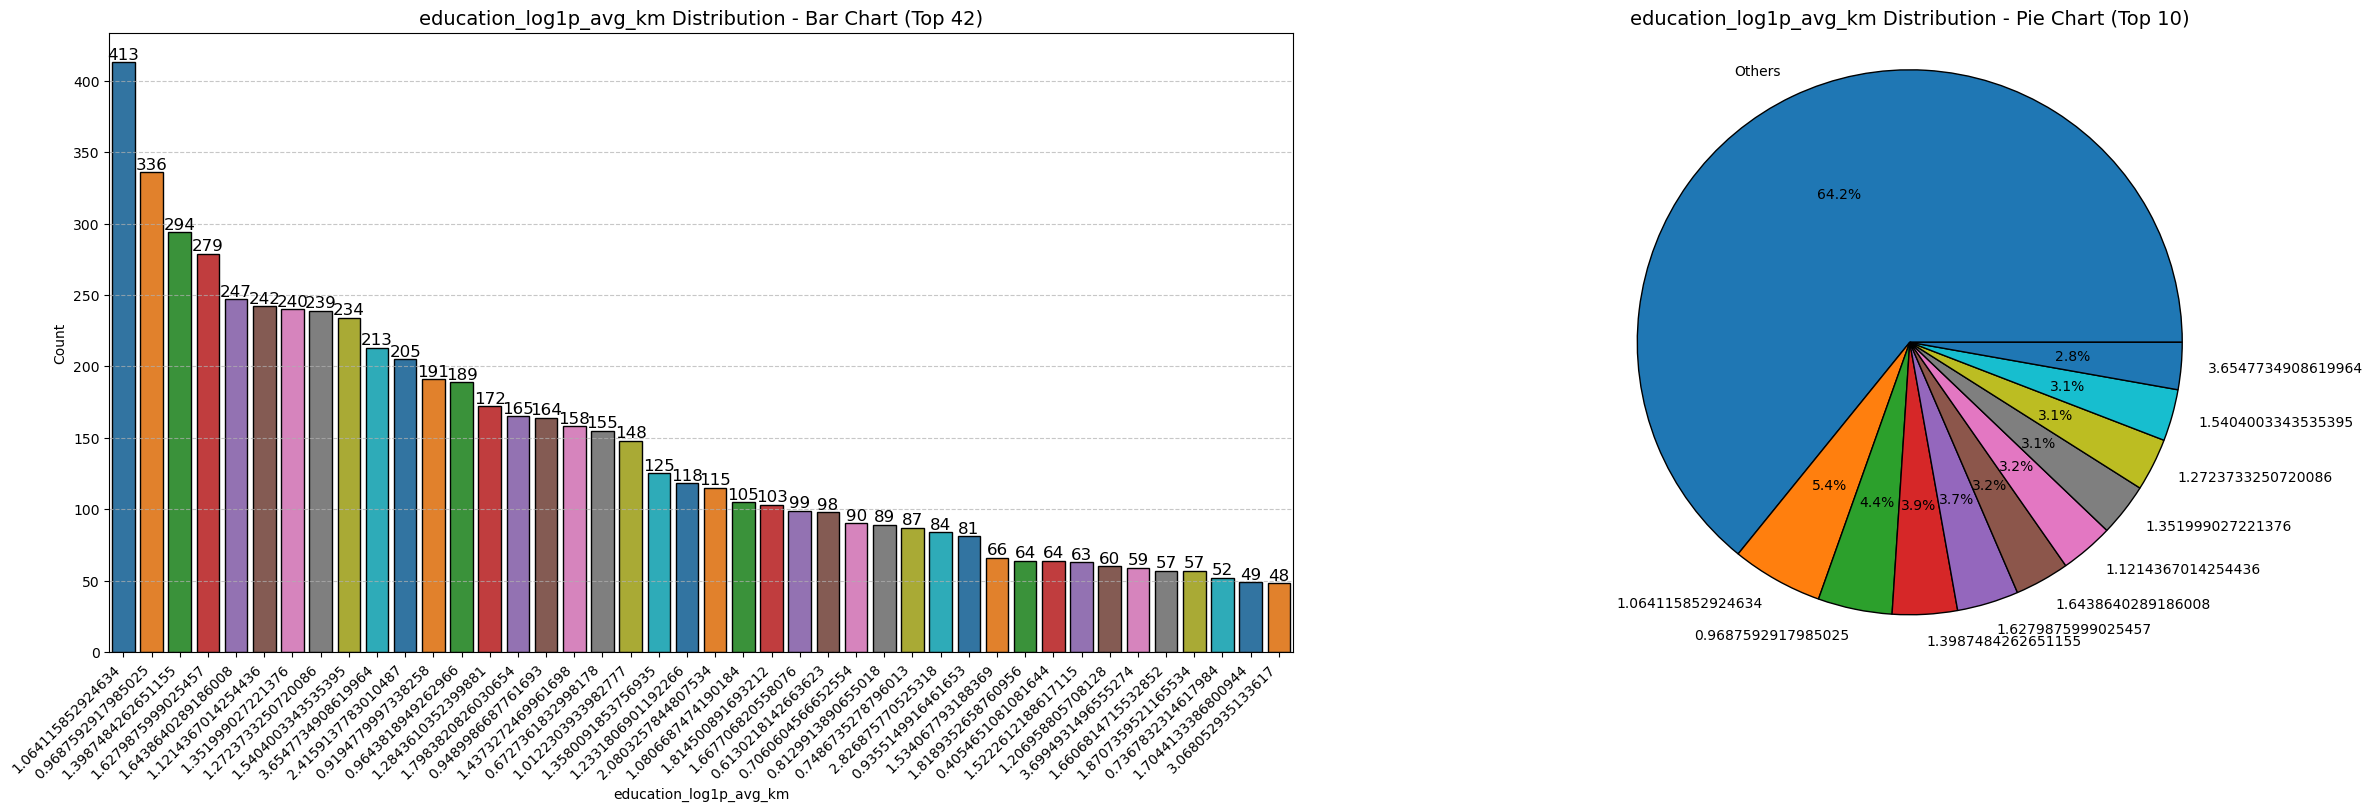

In [139]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'education_log1p_avg_km', bar_top_n=42, pie_top_n=10)

In [140]:
print(f"values less than 0.5 : {df[df['education_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['education_log1p_avg_km'] > 2].shape}")

values less than 0.5 : (159, 51)
--------------------------------------------------
values more than 2 : (854, 51)


`observation` 
- There are 4,258 missing values.
- A value close to 0 indicates that the school or college is near the flat, while a higher value means it is farther away from the flat.
- 0.69, showing moderate variability

In [141]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'education_log1p_avg_km',9, 0.90)

Top 9 cumulative values:
education_log1p_avg_km
1.064116    0.054086
0.968759    0.098088
1.398748    0.136590
1.627988    0.173127
1.643864    0.205474
1.121437    0.237166
1.351999    0.268596
1.272373    0.299895
1.540400    0.330540
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 65 Properties below 90.0% percentile: [0.4054651081081644, 0.5862259500736664, 0.5993383626097382, 0.6130218142663623, 0.6178809498833252, 0.6727361832998178, 0.6931471805599453, 0.7060604566652554, 0.7070486617115761, 0.7316277011280095, 0.7367832314617984, 0.7486735278796013, 0.7548866129133115, 0.7662757033441439, 0.8019544808158491, 0.8119506234904964, 0.8129913890655018, 0.8394680642309454, 0.9194779997338258, 0.9355149916461653, 0.9489986687761693, 0.9622994580257694, 0.9643818949262966, 0.9687592917985025, 1.0122303933982777, 1.0269973725016048, 1.064115852924634, 1.0800297404224661, 1.0806687474190184, 1.08

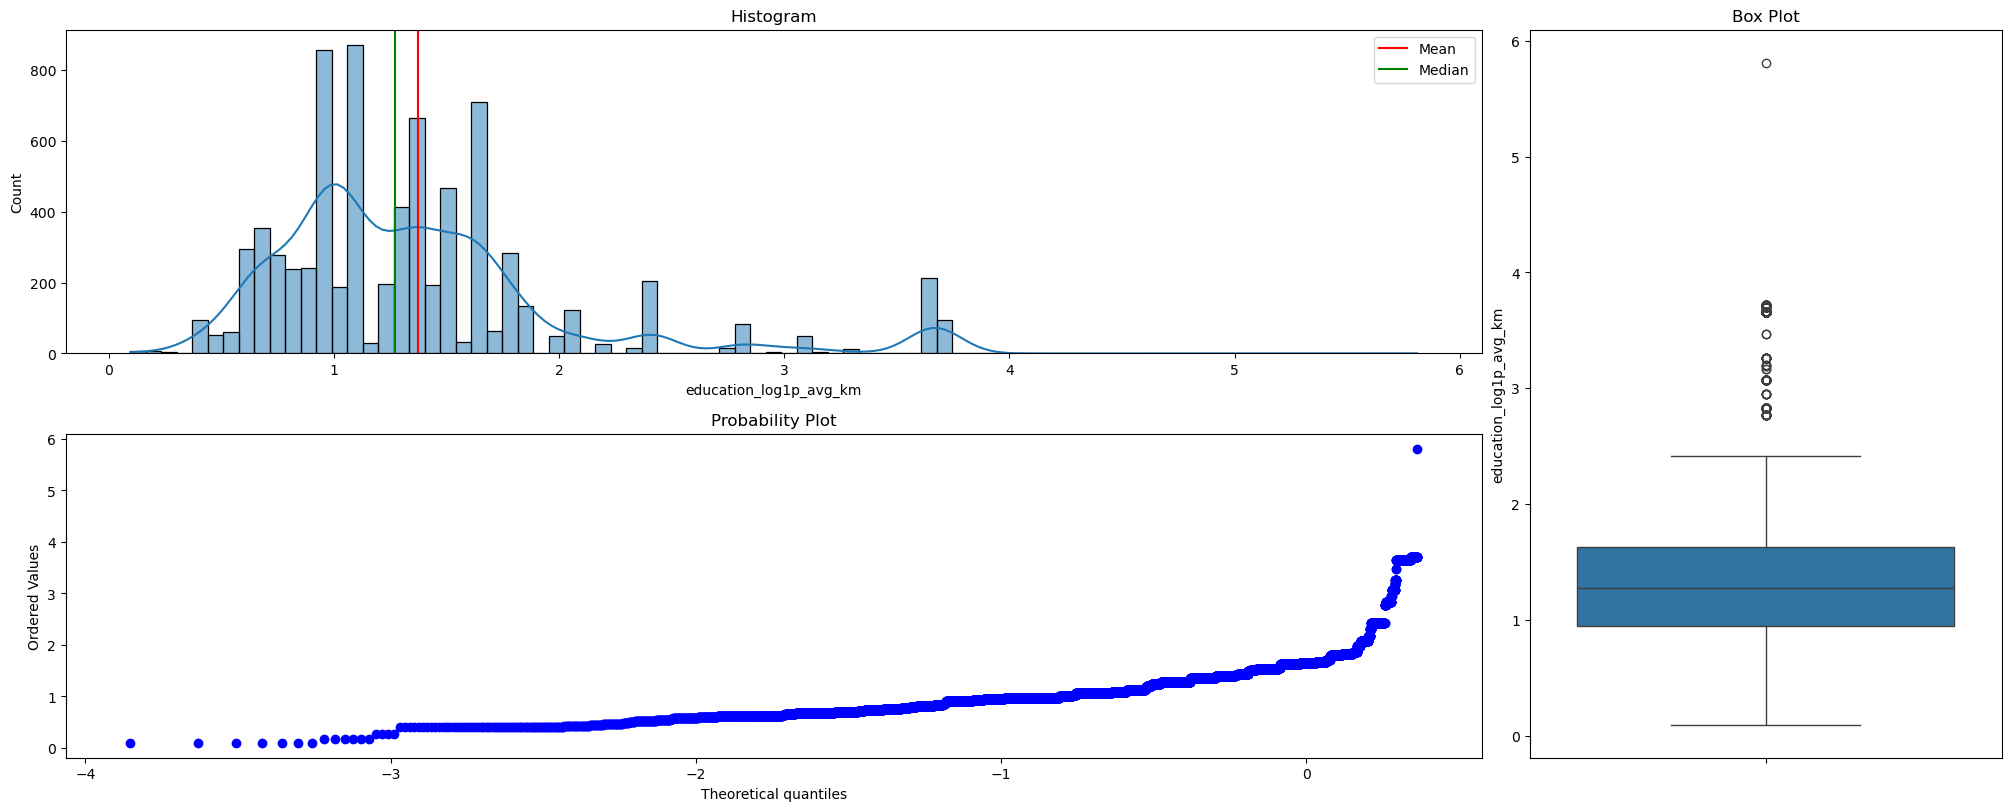

In [142]:
num_three_chart_plot(df, 'education_log1p_avg_km')

`observation` 
- histogram confirms a right-skewed distribution, with most values concentrated at lower log1p distances. 
- The highest frequency is observed around 1.0–1.5 education_log1p_avg_km, indicating that most distances fall within this range
- Sparse values are seen beyond 3.0 education_log1p_avg_km, suggesting potential outliers
- IQR ranges from 0.95 (25th percentile) to 1.63 (75th percentile).
- Outliers are present above 2.6 education_log1p_avg_km.

In [143]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'education_log1p_avg_km', quantiles_input)

skewness : 1.720089
kurtosis : 3.470946
--------------------------------------------------------------------
Q1 (25th percentile): 0.9490
Q3 (75th percentile): 1.6280
IQR: 0.6790
Lower bound: -0.0695
Upper bound: 2.6465
--------------------------------------------------------------------
10th percentile   0.7061
75th percentile   1.6280


`observation` 
- Skewness: 1.72, indicating a right-skewed distribution.
- Kurtosis: 3.47, suggesting thleptokurtic e distribution has heavier tails and is more peaked compared to a normal distribution.

# transport

In [144]:
# Example usage
process_km_column(df, 'transport')

Columns that were created: 'transport_extracted_km', 'transport_log1p_avg_km'


In [145]:
df['transport_extracted_km'].sample(5)

34                [0.6, 38.1, 1.0]
3769               [8.5, 0.7, 0.0]
9928     [1.9, 2.9, 4.4, 2.3, 2.3]
11674                         None
11583                   [3.1, 1.8]
Name: transport_extracted_km, dtype: object

In [146]:
# no of unique categories and value_counts
analyze_value_counts(df, 'transport_log1p_avg_km', top_n=5)  

Unique Categories in 'transport_log1p_avg_km': 109
--------------------------------------------------
transport_log1p_avg_km
1.220303    413
0.000000    347
1.001415    336
1.420077    294
1.280934    284
Name: count, dtype: int64


In [147]:
#missing values and describe
analyze_column(df, 'transport_log1p_avg_km')

Missing Values in 'transport_log1p_avg_km': 6252
--------------------------------------------------
count    5642.000000
mean        1.182005
std         0.672906
min         0.000000
25%         0.875469
50%         1.208849
75%         1.420077
max         6.747821
Name: transport_log1p_avg_km, dtype: float64


`observation`
- Mean (1.18) < Median (1.21) → Slightly left-skewed distribution.
- Std (0.67) → Moderate variability.
- Min (0.00), Max (6.75) → Values range from 0 to 6.75, with a possible outlier at the upper end.
- 25% (0.88), 75% (1.42) → 50% of values between 0.88 and 1.42.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


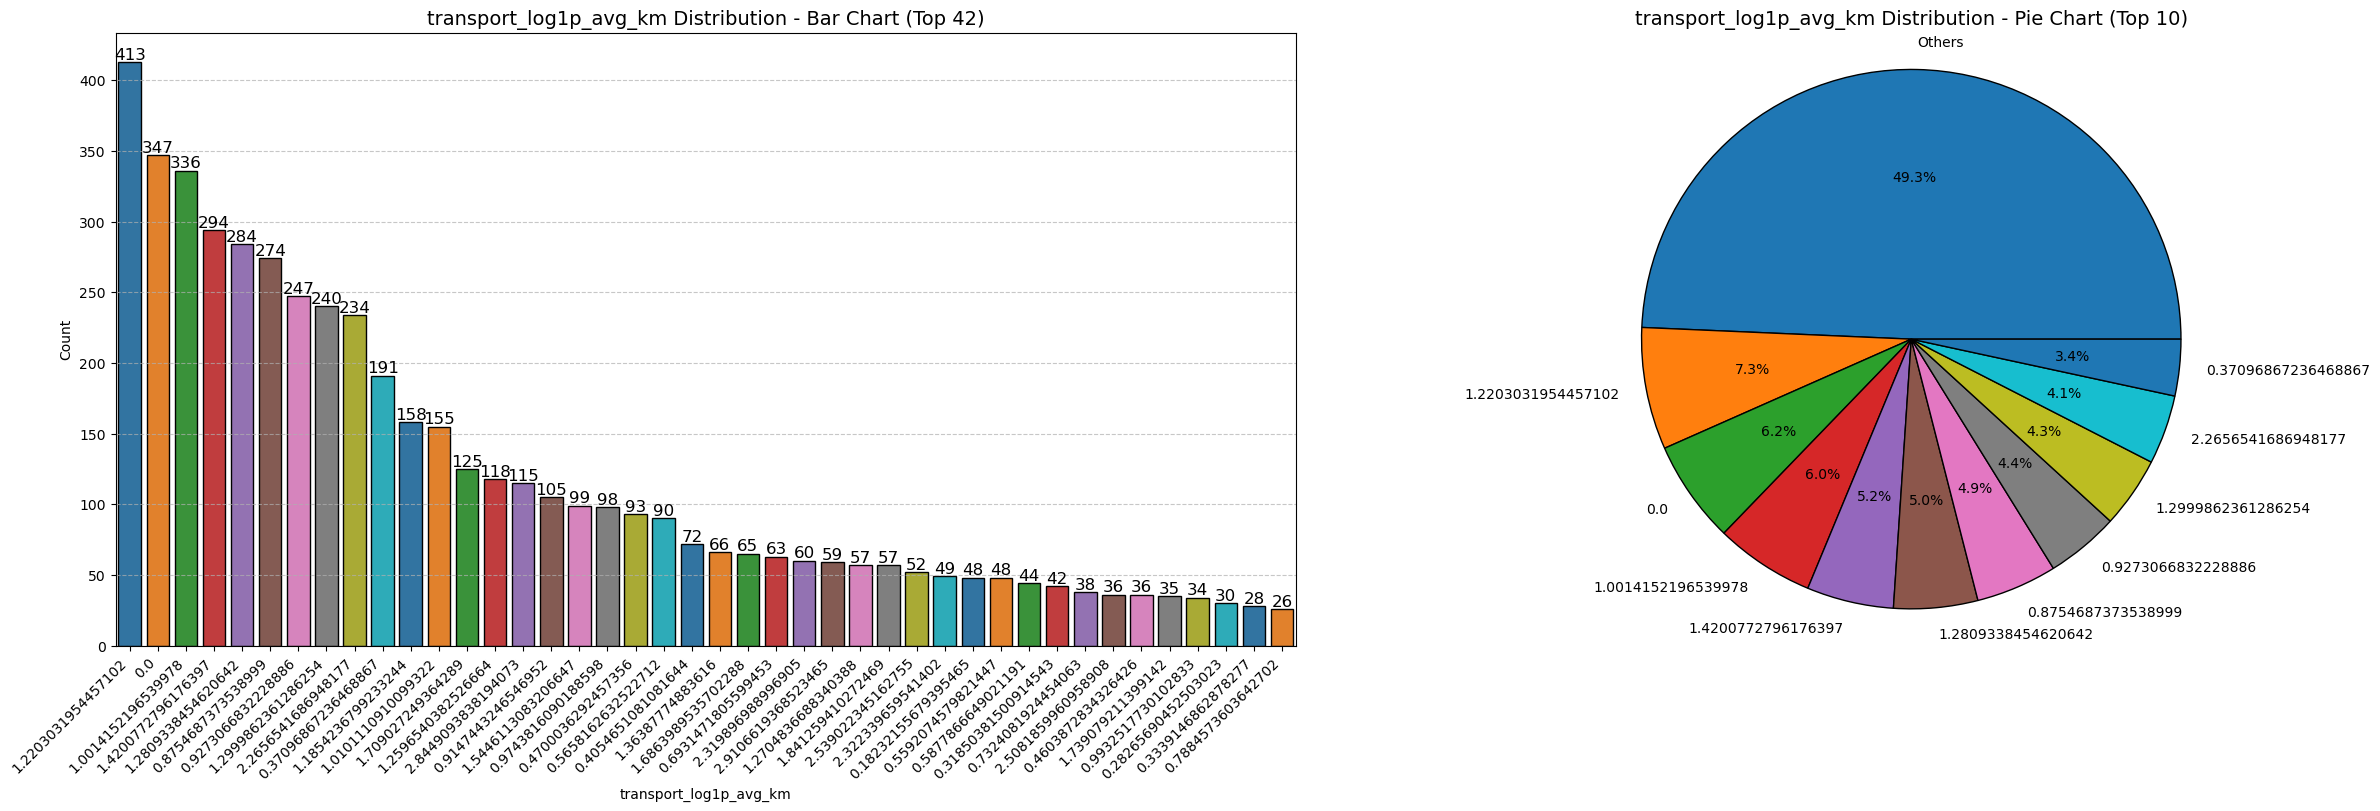

In [148]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'transport_log1p_avg_km', bar_top_n=42, pie_top_n=10)

In [149]:
print(f"values less than 0.5 : {df[df['transport_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['transport_log1p_avg_km'] > 2].shape}")

values less than 0.5 : (934, 53)
--------------------------------------------------
values more than 2 : (659, 53)


`observation` 
- There are 6252 missing values.
- A value close to 0 indicates that the transport facility is near the flat, while a higher value means it is farther away from the flat.
- 0.67, showing moderate variability

In [150]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'transport_log1p_avg_km',9, 0.90)

Top 9 cumulative values:
transport_log1p_avg_km
1.220303    0.073201
0.000000    0.134704
1.001415    0.194257
1.420077    0.246367
1.280934    0.296703
0.875469    0.345268
0.927307    0.389046
1.299986    0.431585
2.265654    0.473059
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 43 Properties below 90.0% percentile: [0.0, 0.18232155679395465, 0.28265690452503023, 0.31850381500914543, 0.3339146862878277, 0.37096867236468867, 0.4054651081081644, 0.4603872834326426, 0.4700036292457356, 0.5592074579821447, 0.5658162632522712, 0.5877866649021191, 0.6931471805599453, 0.7324081924454063, 0.7884573603642702, 0.8754687373538999, 0.9147443246546952, 0.9273066832228886, 0.9743816090188598, 0.9932517730102833, 1.0014152196539978, 1.0101110910099322, 1.1854236799233244, 1.2203031954457102, 1.2596540382526664, 1.2704836688340388, 1.2809338454620642, 1.2999862361286254, 1.36387774883616, 1.42007727961763

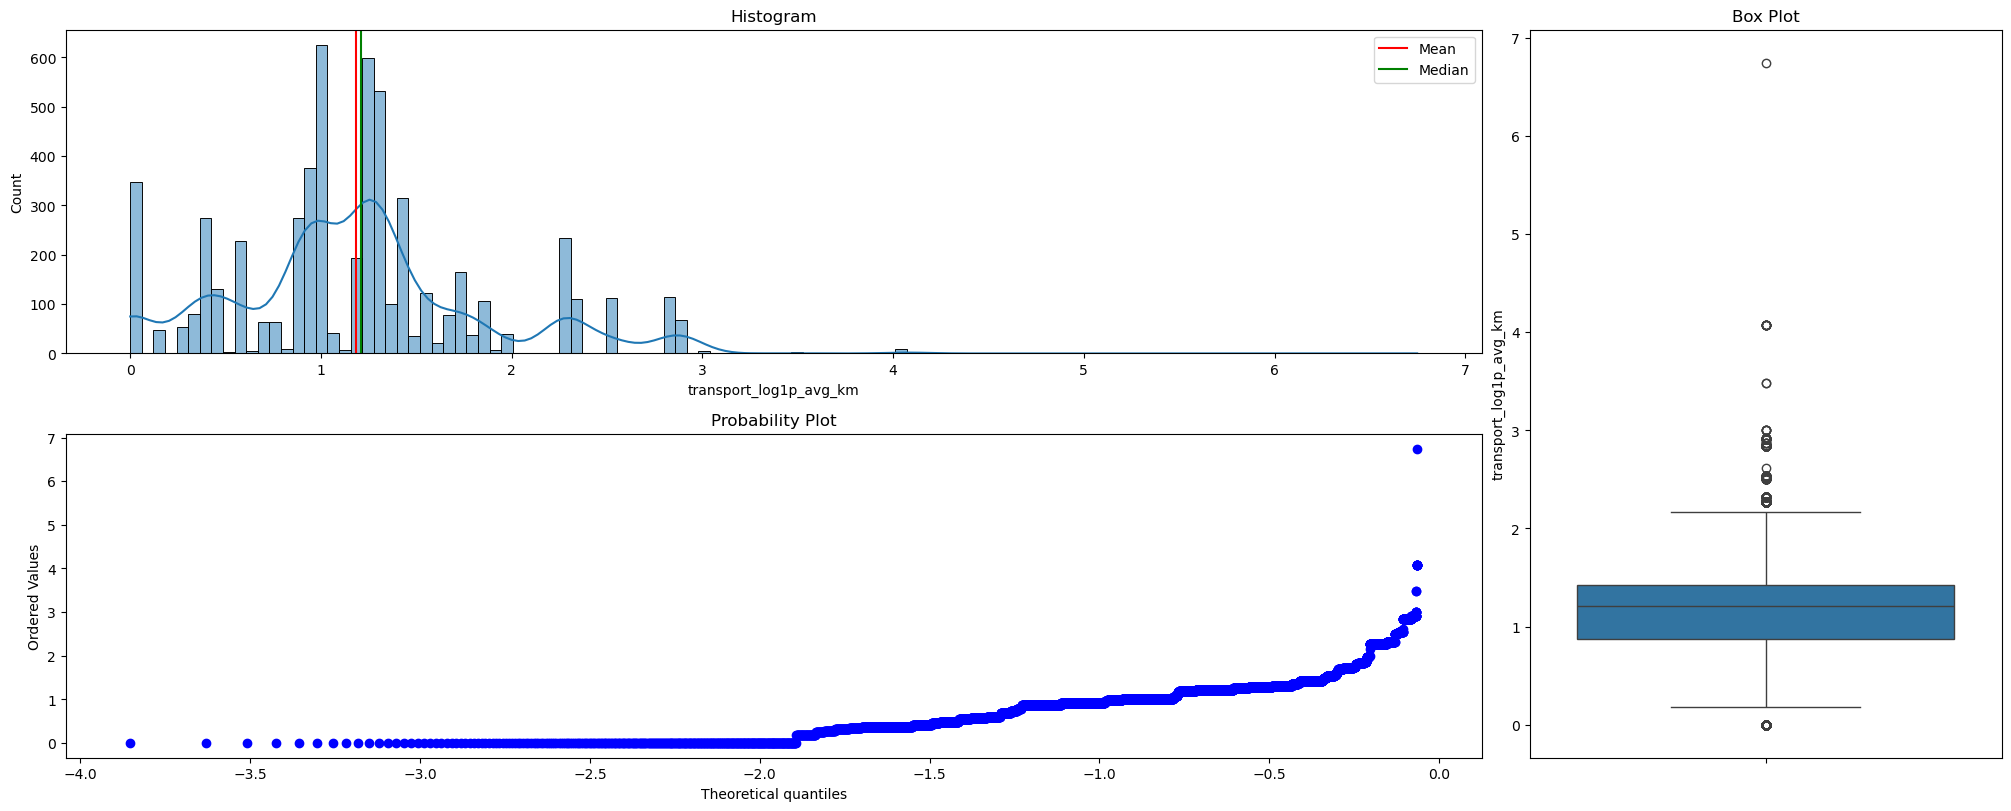

In [151]:
num_three_chart_plot(df, 'transport_log1p_avg_km')

`observation` 
- histogram confirms a right-skewed distribution, with most values concentrated at lower log1p distances. 
- The highest frequency is observed around 0.8–1.4 transport_log1p_avg_km, indicating that most distances fall within this range
- Sparse values are seen beyond 2.5 transport_log1p_avg_km, suggesting potential outliers
- IQR ranges from 0.87 (25th percentile) to 1.42 (75th percentile).
- Outliers are present above 2.23 transport_log1p_avg_km.

In [152]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'transport_log1p_avg_km', quantiles_input)

skewness : 0.691612
kurtosis : 1.433172
--------------------------------------------------------------------
Q1 (25th percentile): 0.8755
Q3 (75th percentile): 1.4201
IQR: 0.5446
Lower bound: 0.0586
Upper bound: 2.2370
--------------------------------------------------------------------
10th percentile   0.3710
75th percentile   1.4201


`observation` 
- Skewness: 0.69, data is slightly skewed to the right
- Kurtosis: 1.43, data has light tails (fewer extreme values).

# shopping_centre

In [153]:
# Example usage
process_km_column(df, 'shopping_centre')

Columns that were created: 'shopping_centre_extracted_km', 'shopping_centre_log1p_avg_km'


In [154]:
df['shopping_centre_extracted_km'].sample(5)

3129    [0.7, 6.1, 0.9, 2.2, 2.0]
2505                         None
945                          None
1917    [0.1, 1.2, 2.0, 5.6, 1.5]
618     [1.4, 1.0, 2.3, 3.1, 1.0]
Name: shopping_centre_extracted_km, dtype: object

In [155]:
# no of unique categories and value_counts
analyze_value_counts(df, 'shopping_centre_log1p_avg_km', top_n=5)  

Unique Categories in 'shopping_centre_log1p_avg_km': 183
--------------------------------------------------
shopping_centre_log1p_avg_km
0.973335    413
0.596670    336
0.896485    294
0.465910    279
1.522261    247
Name: count, dtype: int64


In [156]:
#missing values and describe
analyze_column(df, 'shopping_centre_log1p_avg_km')

Missing Values in 'shopping_centre_log1p_avg_km': 3880
--------------------------------------------------
count    8014.000000
mean        1.151809
std         0.529706
min         0.095310
25%         0.791697
50%         0.973335
75%         1.551802
max         3.645450
Name: shopping_centre_log1p_avg_km, dtype: float64


`observation`
- Mean (1.15) < Median (0.97) → Left-skewed distribution.
- Std (0.53) → Low to moderate variability.
- Min (0.10), Max (3.65) → Values range from 0.10 to 3.65, no extreme outliers.
- 25% (0.79), 75% (1.55) → 50% of values between 0.79 and 1.55.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


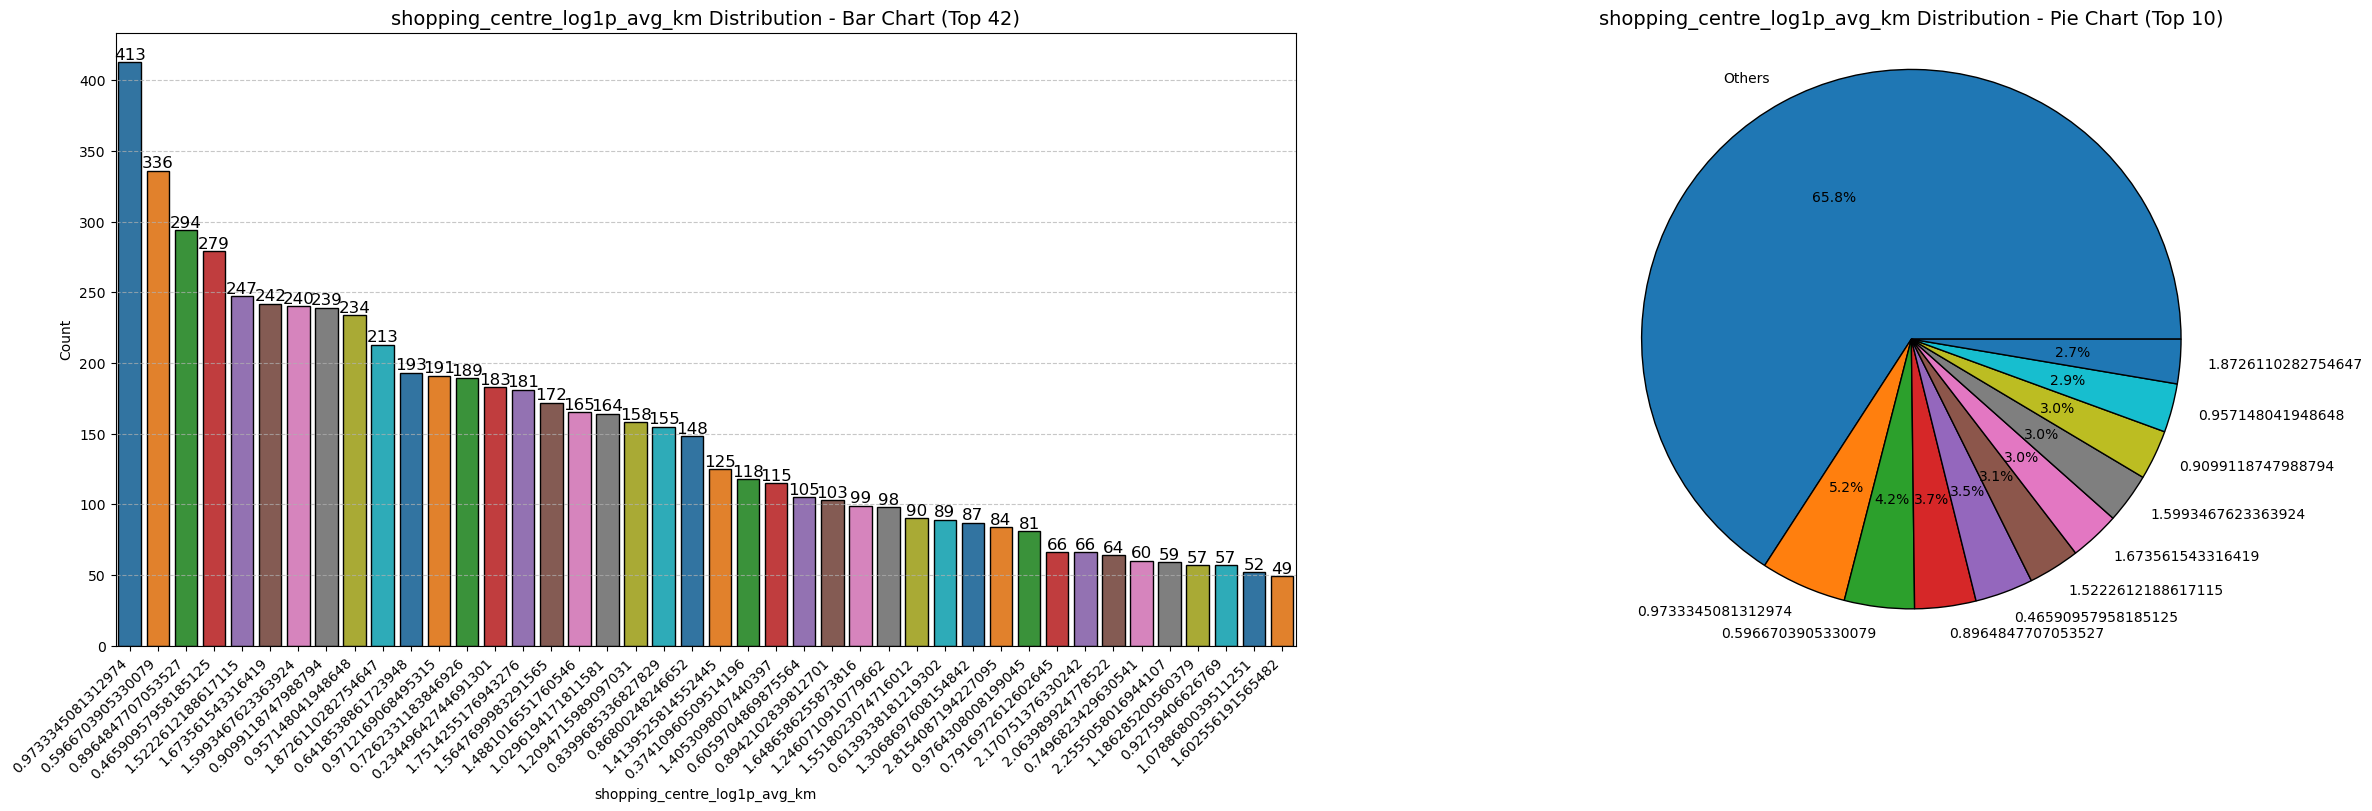

In [157]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'shopping_centre_log1p_avg_km', bar_top_n=42, pie_top_n=10)

In [158]:
print(f"values less than 0.5 : {df[df['shopping_centre_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['shopping_centre_log1p_avg_km'] > 2].shape}")

values less than 0.5 : (706, 55)
--------------------------------------------------
values more than 2 : (531, 55)


`observation` 
- There are 3880 missing values.
- A value close to 0 indicates that the shopping centre is near the flat, while a higher value means it is farther away from the flat.
- 0.52, showing moderate variability

In [159]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'shopping_centre_log1p_avg_km',9, 0.90)

Top 9 cumulative values:
shopping_centre_log1p_avg_km
0.973335    0.051535
0.596670    0.093461
0.896485    0.130147
0.465910    0.164961
1.522261    0.195782
1.673562    0.225980
1.599347    0.255927
0.909912    0.285750
0.957148    0.314949
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 68 Properties below 90.0% percentile: [0.22518581946371335, 0.23449642744691301, 0.3525967647159516, 0.37410960509514196, 0.46590957958185125, 0.4700036292457356, 0.5306960913663291, 0.5842448442757858, 0.5966703905330079, 0.6059704869875564, 0.6139338181219302, 0.6418538861723948, 0.6595428057132202, 0.7262331183846926, 0.7419360592534555, 0.7496823429630541, 0.7916972612602645, 0.8399685336827829, 0.8523740461192126, 0.86800248246652, 0.8942102839812701, 0.8964847707053527, 0.9099118747988794, 0.9238288189106884, 0.92759406626769, 0.957148041948648, 0.9712169068495315, 0.9733345081312974, 0.9764308008199045

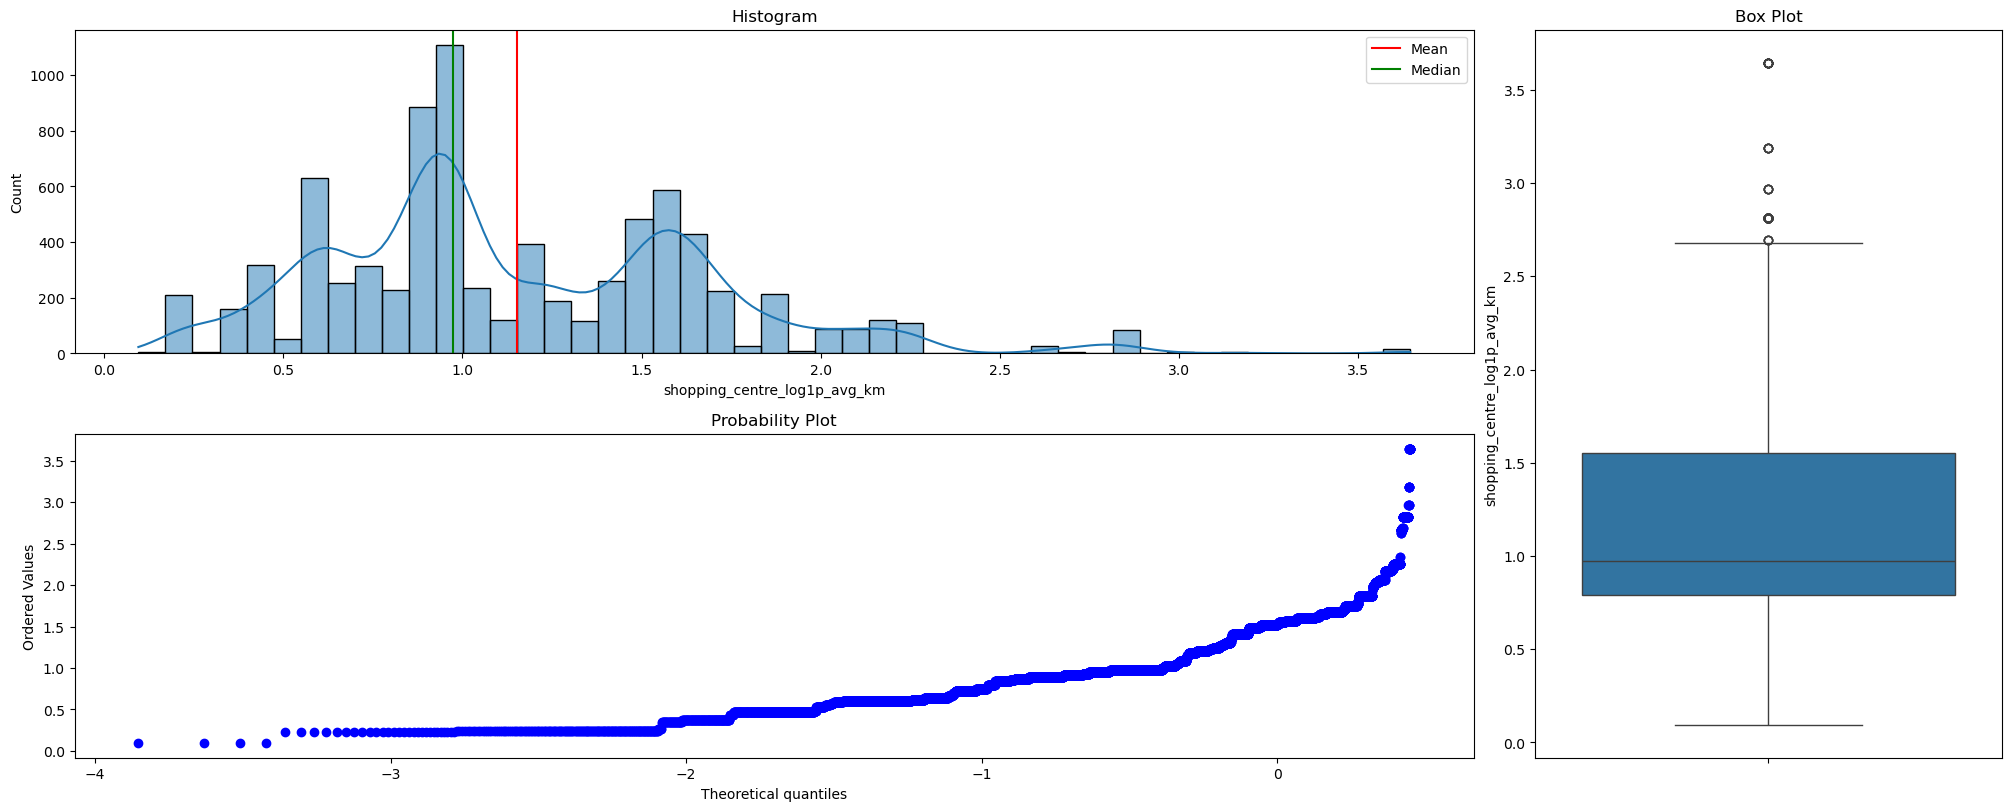

In [160]:
num_three_chart_plot(df, 'shopping_centre_log1p_avg_km')

`observation` 
- histogram confirms a right-skewed distribution, with most values concentrated at lower log1p distances. 
- The highest frequency is observed around 0.8–1.55 shopping_centre_log1p_avg_km, indicating that most distances fall within this range
- Sparse values are seen beyond 2.7 shopping_centre_log1p_avg_km, suggesting potential outliers
- IQR ranges from 0.8 (25th percentile) to 1.55 (75th percentile).
- The median (0.97) is closer to the lower quartile, indicating right skewness.
- Outliers are present above 2.7 shopping_centre_log1p_avg_km.

In [161]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'shopping_centre_log1p_avg_km', quantiles_input)

skewness : 0.777006
kurtosis : 0.966763
--------------------------------------------------------------------
Q1 (25th percentile): 0.7917
Q3 (75th percentile): 1.5518
IQR: 0.7601
Lower bound: -0.3485
Upper bound: 2.6920
--------------------------------------------------------------------
10th percentile   0.5842
75th percentile   1.5518


`observation` 
- Skewness: 0.77, indicating a moderate right-skewed distribution.
- Kurtosis: 0.96, suggests that the distribution is slightly more peaked and has heavier tails compared to a normal distribution.

# commercial_hub

In [162]:
# Example usage
process_km_column(df, 'commercial_hub')

Columns that were created: 'commercial_hub_extracted_km', 'commercial_hub_log1p_avg_km'


In [163]:
df['commercial_hub_extracted_km'].sample(5)

3613          None
9869          None
3181    [4.6, 3.4]
8864          None
7382          None
Name: commercial_hub_extracted_km, dtype: object

In [164]:
# no of unique categories and value_counts
analyze_value_counts(df, 'commercial_hub_log1p_avg_km', top_n=5)  

Unique Categories in 'commercial_hub_log1p_avg_km': 126
--------------------------------------------------
commercial_hub_log1p_avg_km
1.602186    413
0.691896    336
1.743505    294
0.804719    279
2.067979    247
Name: count, dtype: int64


In [165]:
#missing values and describe
analyze_column(df, 'commercial_hub_log1p_avg_km')

Missing Values in 'commercial_hub_log1p_avg_km': 5143
--------------------------------------------------
count    6751.000000
mean        1.700464
std         0.725126
min         0.095310
25%         1.136224
50%         1.602186
75%         2.067979
max         5.773606
Name: commercial_hub_log1p_avg_km, dtype: float64


`observation`
- Mean (1.70) < Median (1.60) → Left-skewed distribution.
- Std (0.73) → Moderate variability.
- Min (0.10), Max (5.77) → Values range from 0.10 to 5.77, no extreme outliers.
- 25% (1.14), 75% (2.07) → 50% of values between 1.14 and 2.07.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


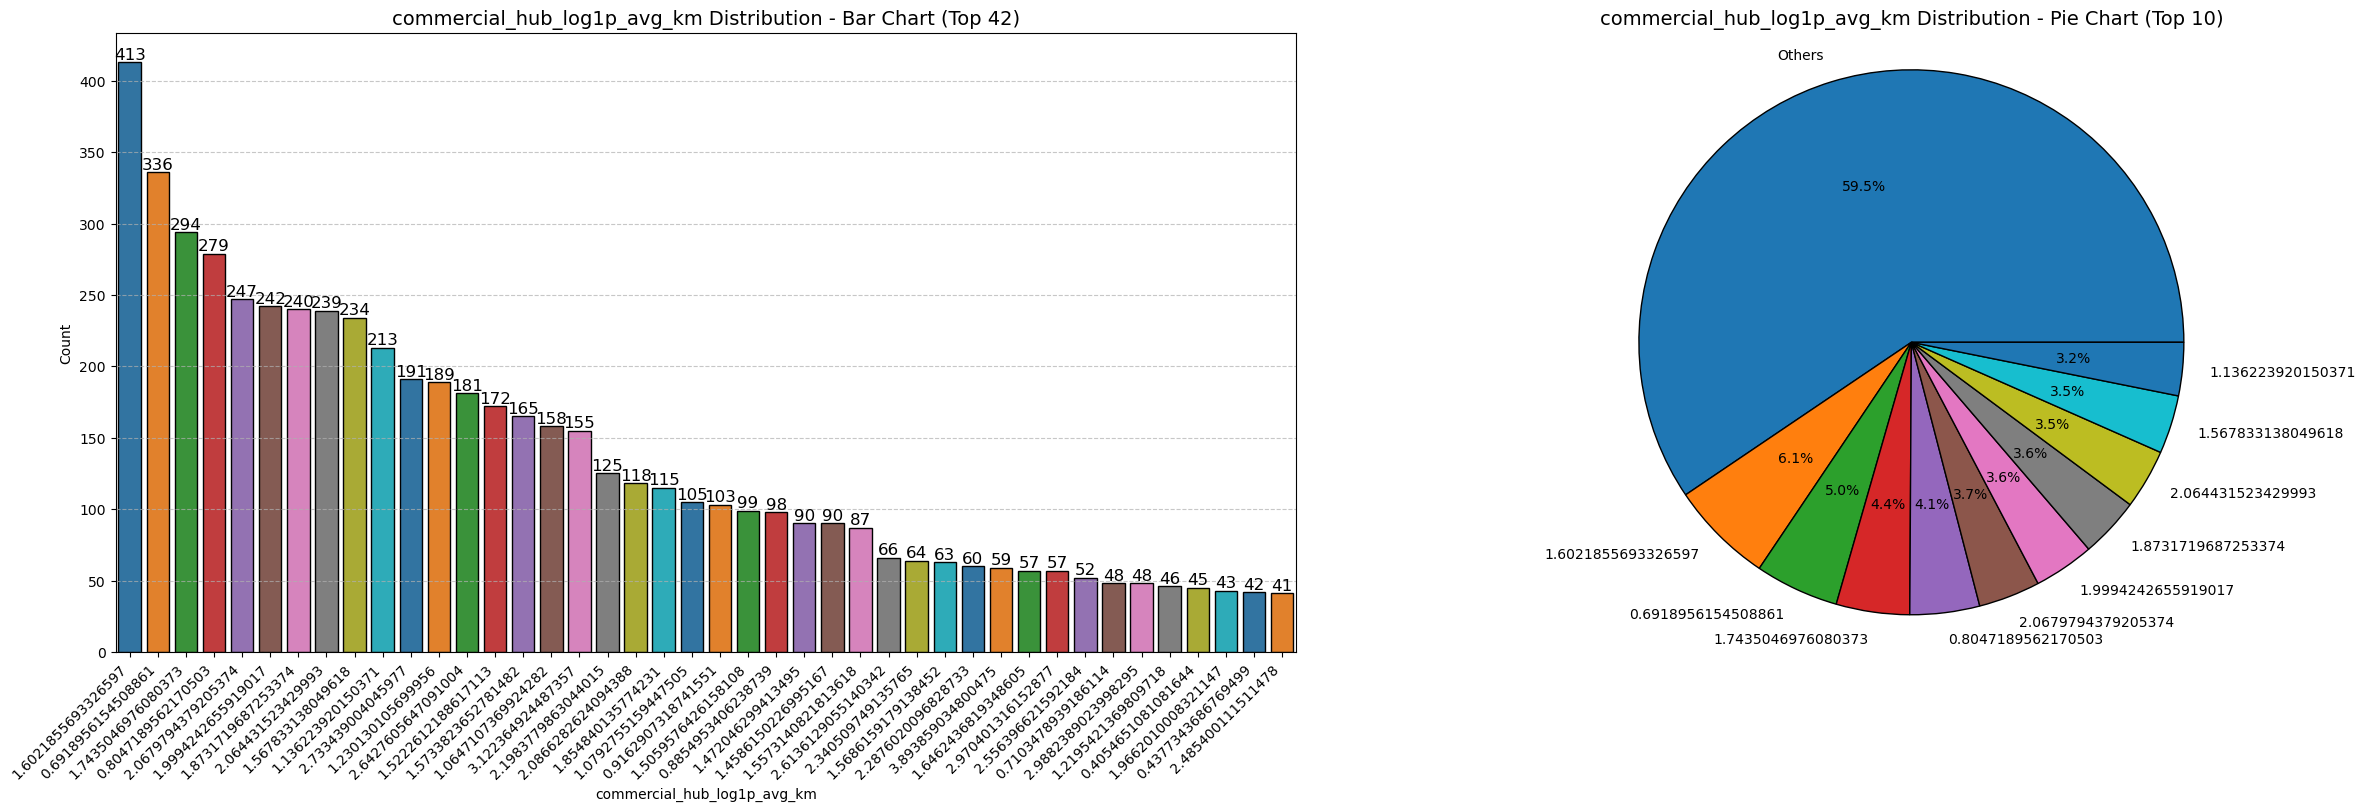

In [166]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'commercial_hub_log1p_avg_km', bar_top_n=42, pie_top_n=10)

In [167]:
print(f"values less than 0.5 : {df[df['commercial_hub_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['commercial_hub_log1p_avg_km'] > 2].shape}")

values less than 0.5 : (150, 57)
--------------------------------------------------
values more than 2 : (2021, 57)


`observation` 
- There are 5143 missing values.
- A value close to 0 indicates that the commercial_hub is near the flat, while a higher value means it is farther away from the flat.
- 0.72, showing moderate variability

In [168]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'commercial_hub_log1p_avg_km',9, 0.90)

Top 9 cumulative values:
commercial_hub_log1p_avg_km
1.602186    0.061176
0.691896    0.110947
1.743505    0.154496
0.804719    0.195823
2.067979    0.232410
1.999424    0.268257
1.873172    0.303807
2.064432    0.339209
1.567833    0.373871
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 52 Properties below 90.0% percentile: [0.09531017980432487, 0.4054651081081644, 0.4377343686769499, 0.6161164547208036, 0.6918956154508861, 0.6931471805599453, 0.7103478939186114, 0.7481160755818659, 0.8047189562170503, 0.8854953406238739, 0.9162907318741551, 1.0647107369924282, 1.0792755159447505, 1.136223920150371, 1.2195421369809718, 1.229236416788302, 1.230130105699956, 1.4586150226995167, 1.472046299413495, 1.5059576426158108, 1.5222612188617113, 1.5573140821813618, 1.567833138049618, 1.5686159179138452, 1.5733823652781482, 1.6021855693326597, 1.6112595922444533, 1.6462436819348605, 1.7435046976080373, 1.

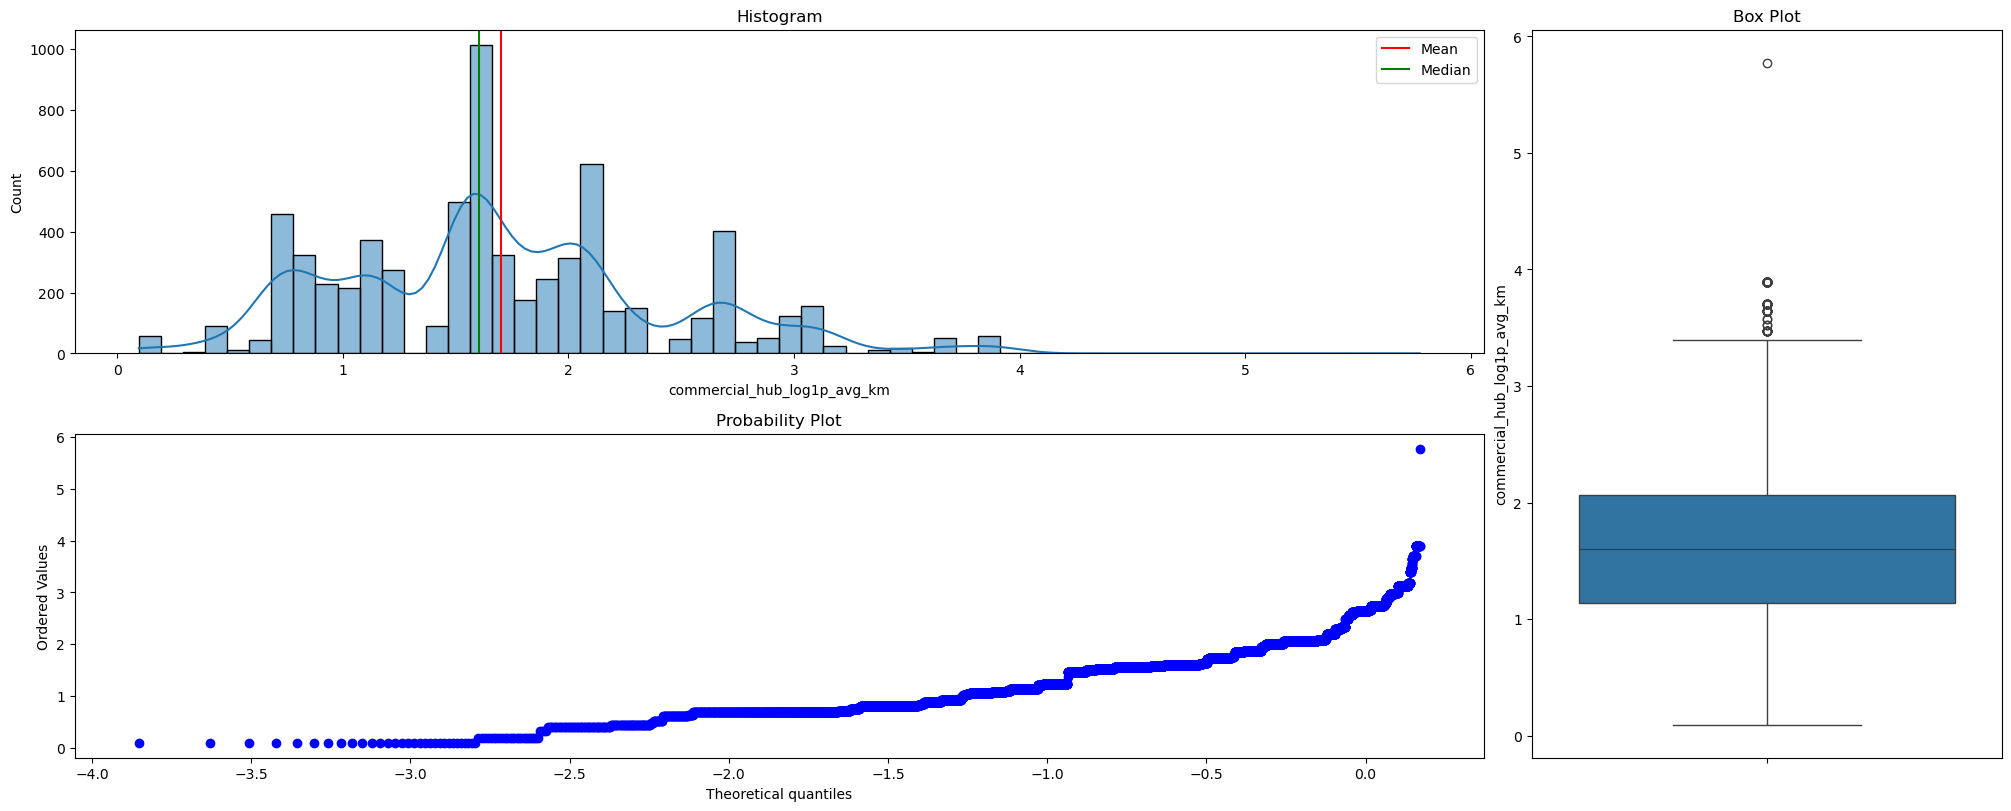

In [169]:
num_three_chart_plot(df, 'commercial_hub_log1p_avg_km')

`observation` 
- histogram confirms a right-skewed distribution, with most values concentrated at lower log1p distances. 
- The highest frequency is observed around 1.13–2.0 commercial_hub_log1p_avg_km, indicating that most distances fall within this range
- Sparse values are seen beyond 3.4 commercial_hub_log1p_avg_km, suggesting potential outliers 
- IQR ranges from 1.13 (25th percentile) to 2.0 (75th percentile).
- Outliers are present above 3.4 commercial_hub_log1p_avg_km.

In [170]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'commercial_hub_log1p_avg_km', quantiles_input)

skewness : 0.507828
kurtosis : 0.230717
--------------------------------------------------------------------
Q1 (25th percentile): 1.1362
Q3 (75th percentile): 2.0680
IQR: 0.9318
Lower bound: -0.2614
Upper bound: 3.4656
--------------------------------------------------------------------
10th percentile   0.8047
75th percentile   2.0680


`observation` 
- Skewness: 0.50, indicating a moderate right-skewed distribution.
- Kurtosis: 0.23, suggests that the distribution is slightly more peaked and has slightly heavier tails compared to a normal distribution.

# hospital

In [171]:
# Example usage
process_km_column(df, 'hospital')

Columns that were created: 'hospital_extracted_km', 'hospital_log1p_avg_km'


In [172]:
df['hospital_extracted_km'].sample(5)

1786               [0.7]
932                [0.7]
6337     [0.7, 0.9, 2.7]
8653                None
11255               None
Name: hospital_extracted_km, dtype: object

In [173]:
# no of unique categories and value_counts
analyze_value_counts(df, 'hospital_log1p_avg_km', top_n=5)  

Unique Categories in 'hospital_log1p_avg_km': 35
--------------------------------------------------
hospital_log1p_avg_km
0.530628    268
0.877032    247
0.723459    239
0.240416    234
0.587787    230
Name: count, dtype: int64


In [174]:
#missing values and describe
analyze_column(df, 'hospital_log1p_avg_km')

Missing Values in 'hospital_log1p_avg_km': 8703
--------------------------------------------------
count    3191.000000
mean        0.686879
std         0.255828
min         0.150995
25%         0.530628
50%         0.723459
75%         0.832909
max         1.526056
Name: hospital_log1p_avg_km, dtype: float64


`observation`
- Mean (0.69) < Median (0.72) → Left-skewed distribution.
- Std (0.26) → Low to moderate variability.
- Min (0.15), Max (1.53) → Values range from 0.15 to 1.53, no extreme outliers.
- 25% (0.53), 75% (0.83) → 50% of values between 0.53 and 0.83.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


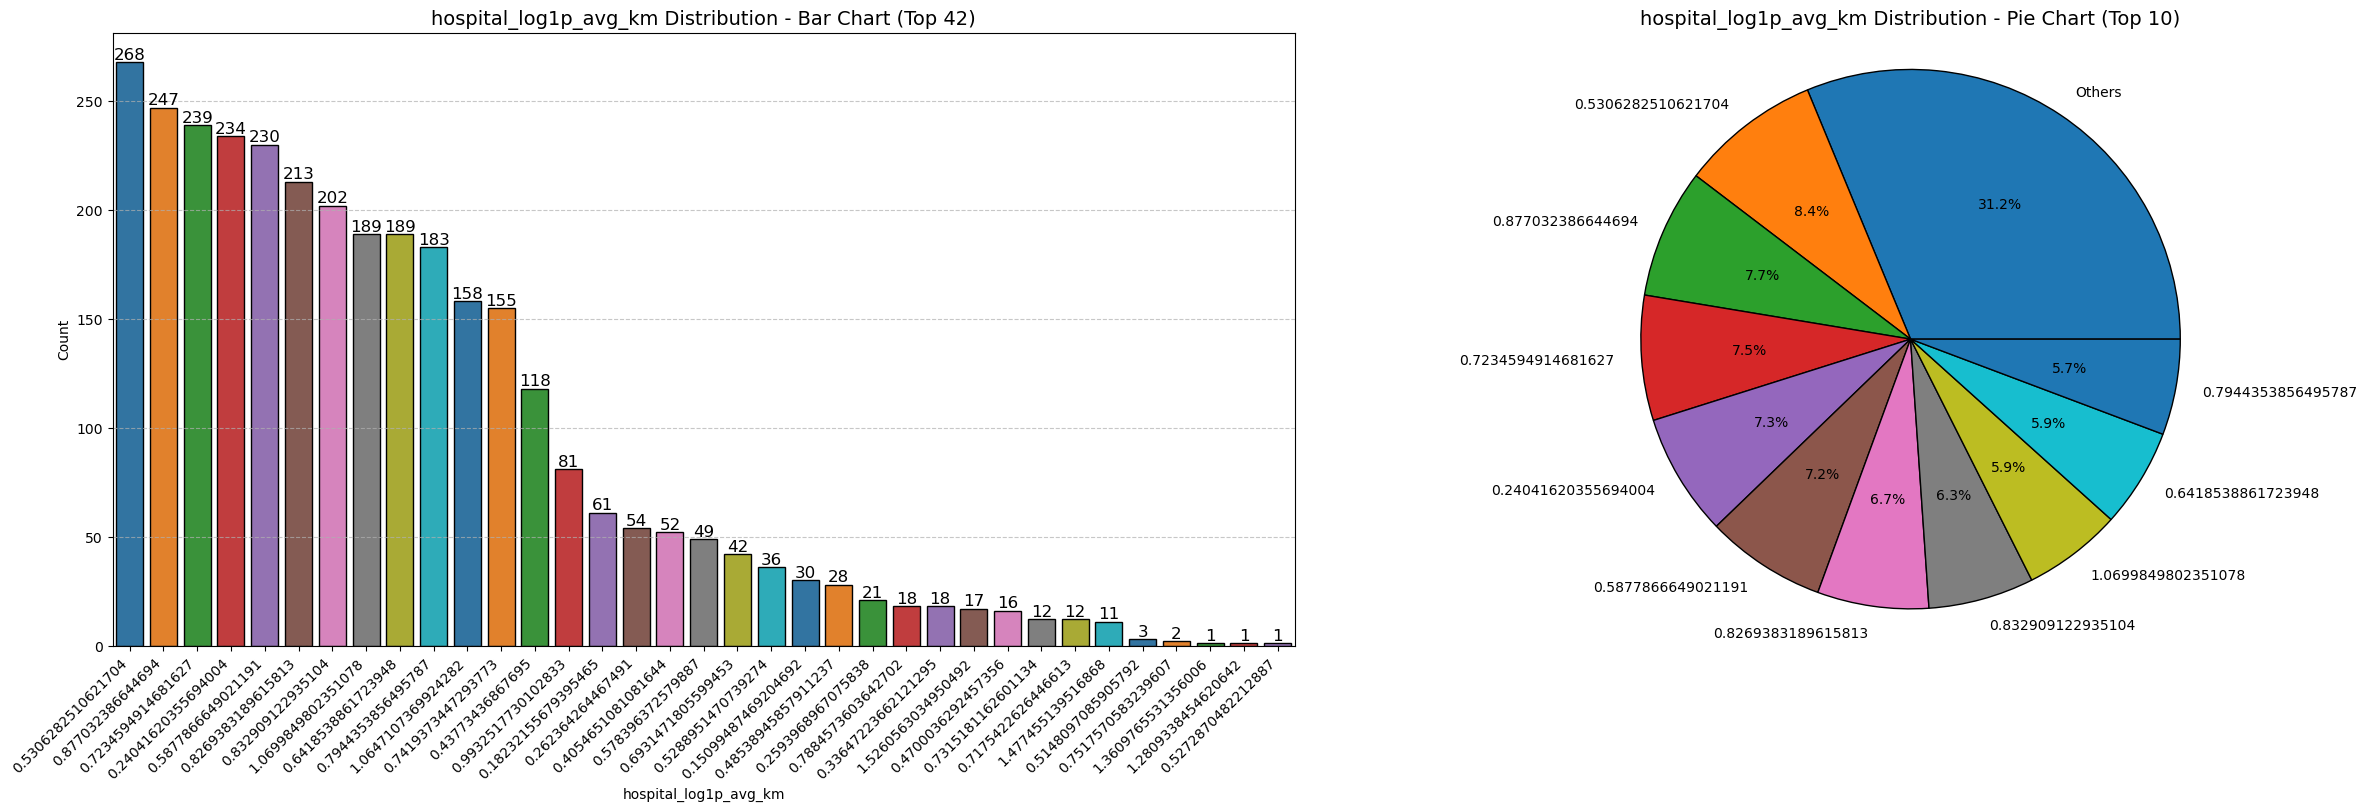

In [175]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'hospital_log1p_avg_km', bar_top_n=42, pie_top_n=10)

In [176]:
print(f"values less than 0.5 : {df[df['hospital_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['hospital_log1p_avg_km'] > 1].shape}")

values less than 0.5 : (632, 59)
--------------------------------------------------
values more than 2 : (377, 59)


`observation` 
- There are 8703 missing values.
- A value close to 0 indicates that the hospital is near the flat, while a higher value means it is farther away from the flat.
- 0.25, showing moderate variability

In [177]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'hospital_log1p_avg_km',9, 0.90)

Top 9 cumulative values:
hospital_log1p_avg_km
0.530628    0.083986
0.877032    0.161391
0.723459    0.236290
0.240416    0.309621
0.587787    0.381699
0.826938    0.448449
0.832909    0.511752
0.641854    0.570981
1.069985    0.630210
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 17 Properties below 90.0% percentile: [0.18232155679395465, 0.24041620355694004, 0.262364264467491, 0.4054651081081644, 0.43773436867695, 0.5306282510621704, 0.5877866649021191, 0.6418538861723948, 0.7234594914681627, 0.7419373447293773, 0.7944353856495787, 0.8269383189615813, 0.832909122935104, 0.877032386644694, 0.9932517730102833, 1.0647107369924282, 1.0699849802351078]


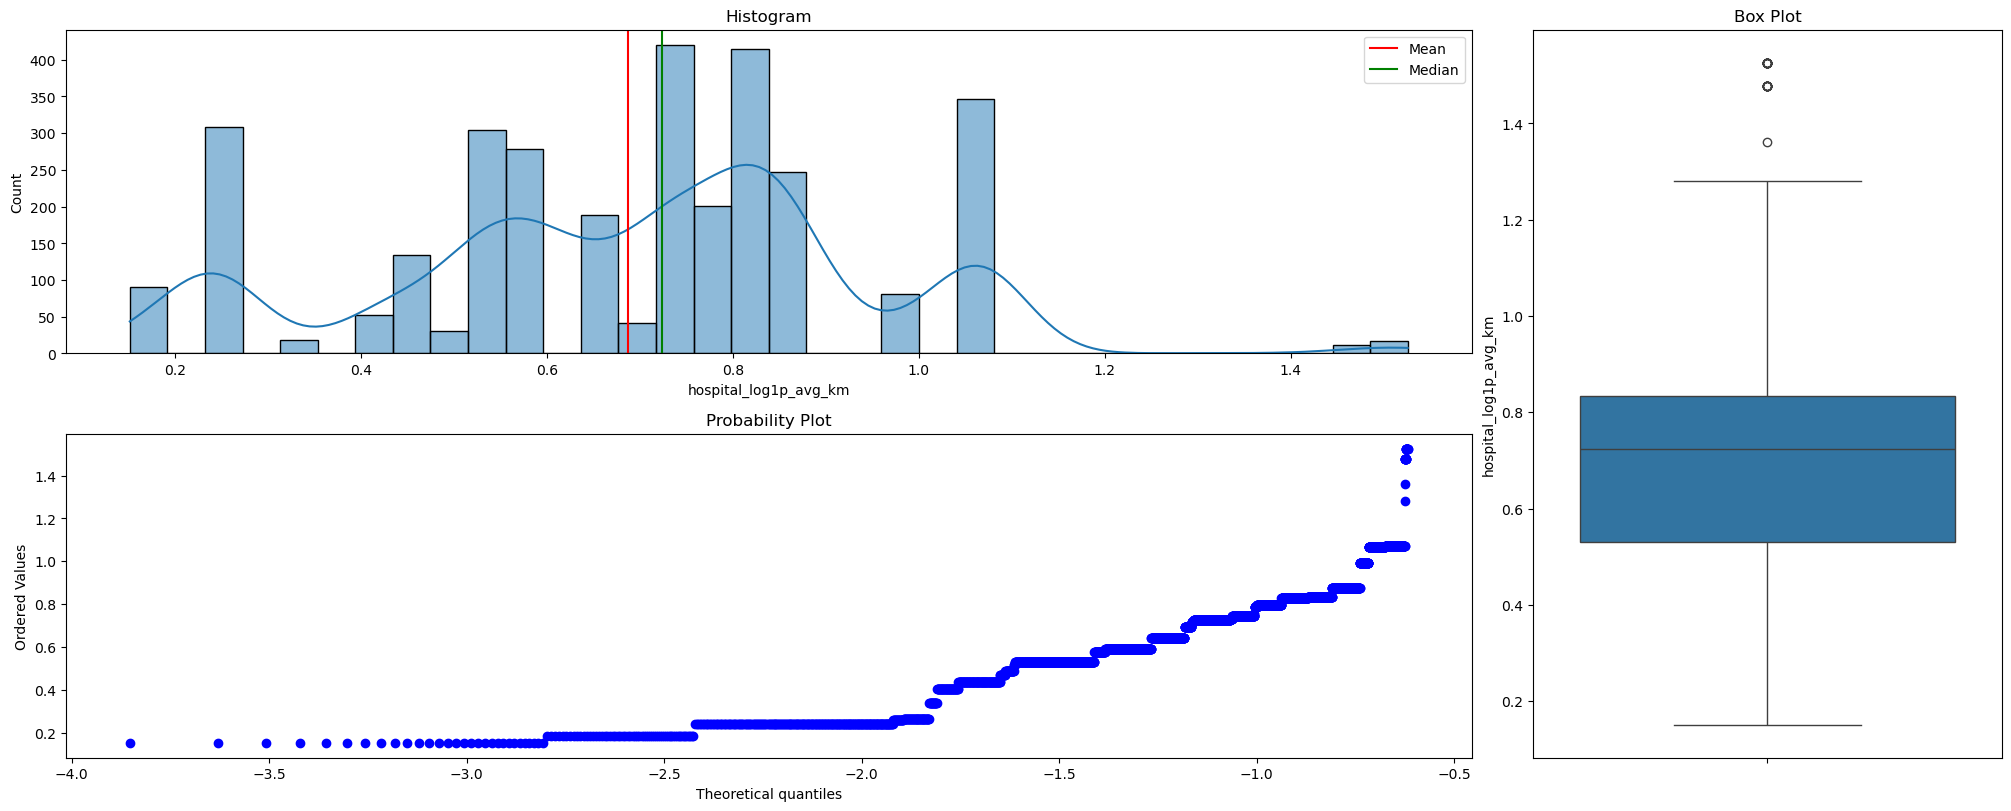

In [178]:
num_three_chart_plot(df, 'hospital_log1p_avg_km')

`observation` 
- histogram confirms a right-skewed distribution, with most values concentrated at lower log1p distances. 
- The highest frequency is observed around 0.53–0.83 hospital_log1p_avg_km, indicating that most distances fall within this range
- fewer observations as the values increase beyond 0.8.
- IQR ranges from 0.53 (25th percentile) to 0.83 (75th percentile).
- Outliers are present above 1.28 hospital_log1p_avg_km.

In [179]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'hospital_log1p_avg_km', quantiles_input)

skewness : -0.075139
kurtosis : 0.011968
--------------------------------------------------------------------
Q1 (25th percentile): 0.5306
Q3 (75th percentile): 0.8329
IQR: 0.3023
Lower bound: 0.0772
Upper bound: 1.2863
--------------------------------------------------------------------
10th percentile   0.2404
75th percentile   0.8329


`observation`
- Skewness(-0.075): The data is slightly negatively skewed (close to symmetric).  
- Kurtosis(0.011): The data has nearly zero excess kurtosis, indicating a shape close to a normal distribution.

# tourist

In [180]:
# Example usage
process_km_column(df, 'tourist')

Columns that were created: 'tourist_extracted_km', 'tourist_log1p_avg_km'


In [181]:
df['tourist_extracted_km'].sample(5)

314      None
759      None
10895    None
8539     None
4464     None
Name: tourist_extracted_km, dtype: object

In [182]:
# no of unique categories and value_counts
analyze_value_counts(df, 'tourist_log1p_avg_km', top_n=5)  

Unique Categories in 'tourist_log1p_avg_km': 12
--------------------------------------------------
tourist_log1p_avg_km
0.720268    336
0.731628    279
0.916291    242
0.530628    241
0.641854    189
Name: count, dtype: int64


In [183]:
#missing values and describe
analyze_column(df, 'tourist_log1p_avg_km')

Missing Values in 'tourist_log1p_avg_km': 10392
--------------------------------------------------
count    1502.000000
mean        0.696911
std         0.144829
min         0.095310
25%         0.641854
50%         0.720268
75%         0.731628
max         0.916291
Name: tourist_log1p_avg_km, dtype: float64


`observation`
- Mean (0.70) < Median (0.72) → Left-skewed distribution.
- Std (0.14) → Low variability.
- Min (0.10), Max (0.92) → Values range from 0.10 to 0.92, no extreme outliers.
- 25% (0.64), 75% (0.73) → 50% of values between 0.64 and 0.73.

C:\Users\ABC\AppData\Local\Temp\ipykernel_1884\1782740589.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='count', data=bar_data, ax=ax1, order=bar_data[feature],


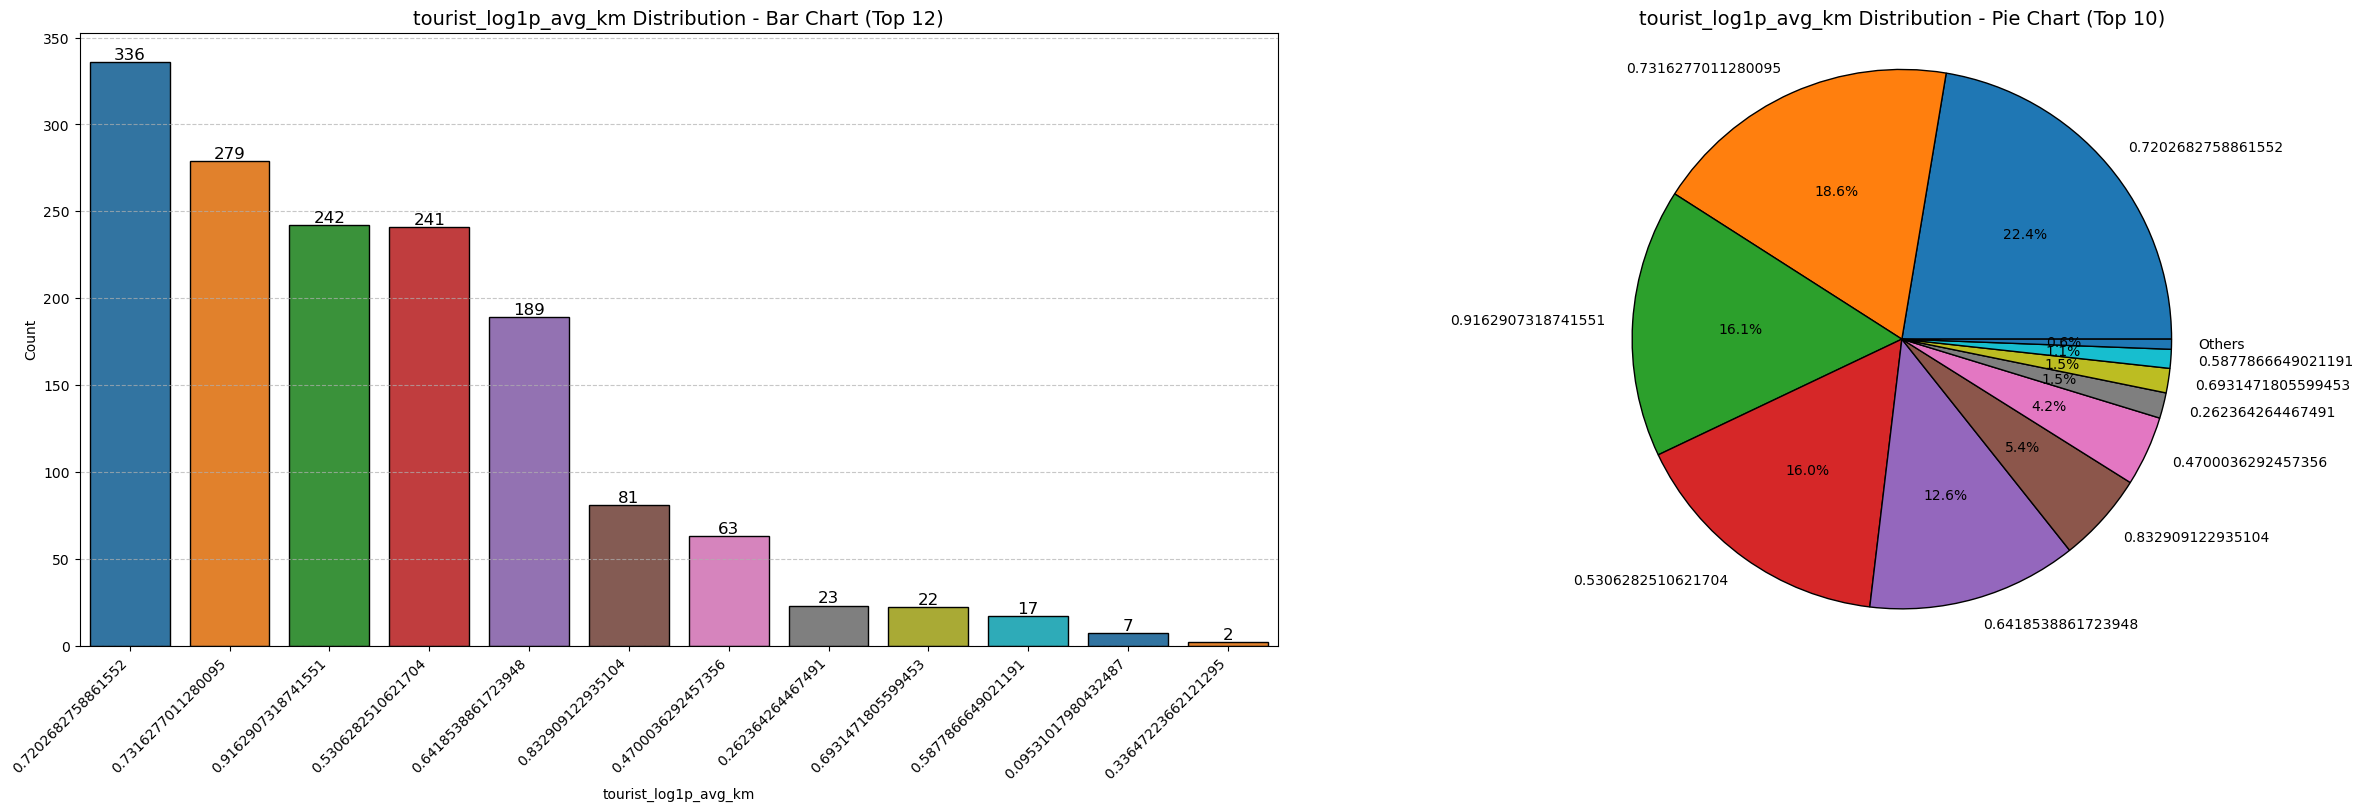

In [184]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'tourist_log1p_avg_km', bar_top_n=12, pie_top_n=10)

In [185]:
print(f"values less than 0.5 : {df[df['tourist_log1p_avg_km'] <= 0.5].shape}")
print("-"*50)
print(f"values more than 2 : {df[df['tourist_log1p_avg_km'] > 0.8].shape}")

values less than 0.5 : (95, 61)
--------------------------------------------------
values more than 2 : (323, 61)


`observation` 
- There are 10392 missing values.
- A value close to 0 indicates that the tourist place is near the flat, while a higher value means it is farther away from the flat.
- 0.14, showing moderate variability

In [186]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'tourist_log1p_avg_km',6, 0.90)

Top 6 cumulative values:
tourist_log1p_avg_km
0.720268    0.223702
0.731628    0.409454
0.916291    0.570573
0.530628    0.731025
0.641854    0.856858
0.832909    0.910786
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------
Total 6 Properties below 90.0% percentile: [0.5306282510621704, 0.6418538861723948, 0.7202682758861552, 0.7316277011280095, 0.832909122935104, 0.9162907318741551]


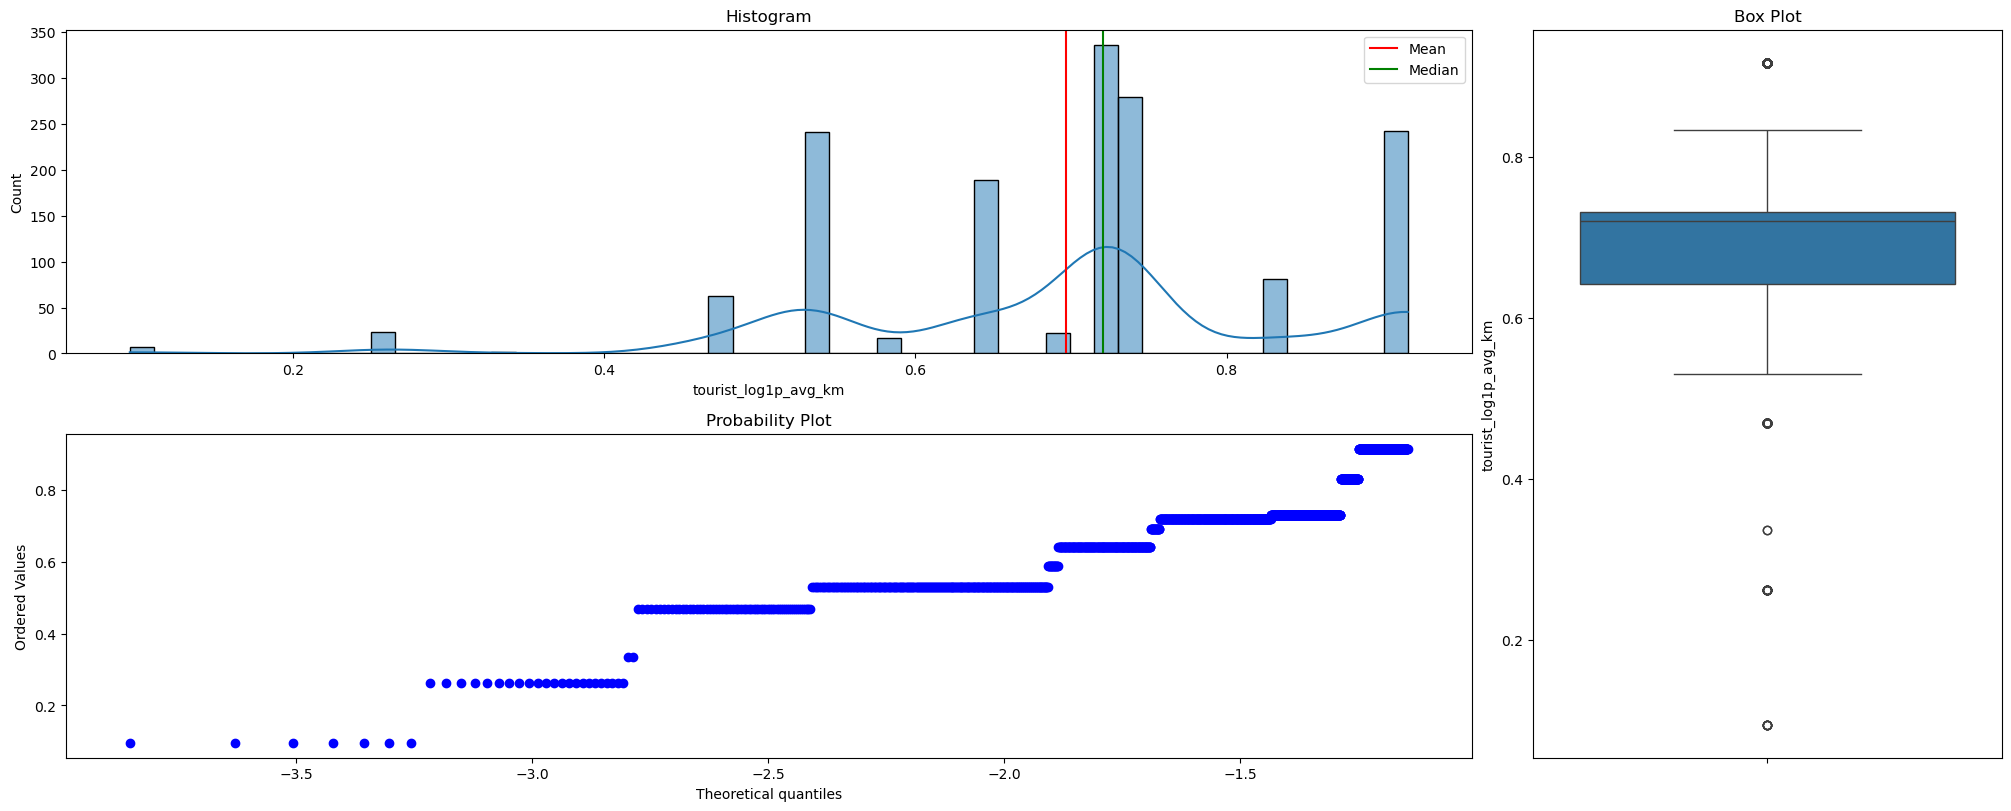

In [187]:
num_three_chart_plot(df, 'tourist_log1p_avg_km')

`observation` 
- histogram confirms a left-skewed distribution, with most values concentrated at higher log1p distances. 
- The highest frequency is observed around 0.6–0.7 tourist_log1p_avg_km, indicating that most distances fall within this range
- IQR ranges from 0.64 (25th percentile) to 0.73 (75th percentile).
- The median (0.72) is closer to the upper quartile, indicating left skewness.
- Outliers are present below 0.50 tourist_log1p_avg_km and above 0.86.

In [188]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'tourist_log1p_avg_km', quantiles_input)

skewness : -0.577111
kurtosis : 1.121608
--------------------------------------------------------------------
Q1 (25th percentile): 0.6419
Q3 (75th percentile): 0.7316
IQR: 0.0898
Lower bound: 0.5072
Upper bound: 0.8663
--------------------------------------------------------------------
10th percentile   0.5306
75th percentile   0.7316


`observation` 
- Skewness (-0.577): The data is moderately negatively skewed.  
- Kurtosis(1.121) : The data has positive kurtosis, indicating a slightly heavier-tailed distribution compared to a normal distribution.

# assigned_amenities_score

In [107]:
# no of unique categories and value_counts
analyze_value_counts(df, 'assigned_amenities_score', top_n=5)  

KeyError: 'assigned_amenities_score'

In [ ]:
#missing values and describe
analyze_column(df, 'assigned_amenities_score')

`observations`
- 5101 missing vaelu
- A lower amenities score indicates fewer and less expensive amenities, while a higher score suggests more amenities, potentially at a lower cost.es.
- The mean (145.88) is higher than the median (113), indicating a right-skewed distribution.
- High variability with a standard deviation of 100.52.
- The maximum score is much higher than the 75th percentile, indicating the presence of outliers in the data.
- Amenities scores range from 5 to 635

In [ ]:
bar_pie_chart_plot(df, 'assigned_amenities_score', bar_top_n=25, pie_top_n=8)

In [ ]:
num_three_chart_plot(df, 'assigned_amenities_score')

`observations`
- The histogram confirms a right-skewed distribution, with most values concentrated at lower scores.
- The highest frequency is observed around 50–100 amenities score.
- Sparse values are seen beyond 400
- IQR ranges from 70 (25th percentile) to 207 (75th percentile).
- The median (113) is closer to the lower quartile, indicating skewness.
- Outliers above 400.
- Whiskers extend from 5 to just above 400., indicating potential outliers.
- The Kernel Density Estimate (KDE) aligns with the histogram, further highlighting the skewness and the presence of a long tail.

In [ ]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'assigned_amenities_score', quantiles_input)

`observation`
- Skewness 1.01, indicating a moderately right-skewed distribution.  
- Kurtosis 0.35, suggesting the distribution is light-tailed compared to a normal distribution.  

In [ ]:
df.groupby("amenities_cluster")["assigned_amenities_score"].mean()

In [ ]:
import seaborn as sns  
sns.boxplot(x=df["amenities_cluster"], y=df["assigned_amenities_score"])

`observation`
- Clear separation → K-Means captured flooring patterns well

# assigned_flooring_score

In [ ]:
# no of unique categories and value_counts
analyze_value_counts(df, 'assigned_flooring_score', top_n=5)  

In [ ]:
#missing values and describe
analyze_column(df, 'assigned_flooring_score')

`observation` 
- work on the flooring column again this time define the weightage for each flooring type
- A lower flooring score indicates fewer and less expensive flooring, while a higher score suggests variety of flooring, potentially at a higher cost.
- 4446 missing values
- Average weightage is 12.93.
- High variability (10.36).
- flooring score ranges from 4 to 56
- 90% of the data have flooring score is this 4,6,7,8,9,10,13,15,,16,17,18,19,22,23,25,26,56

In [ ]:
#bar chart and pie plot 
bar_pie_chart_plot(df, 'assigned_flooring_score', bar_top_n=46, pie_top_n=10)

In [ ]:
#Filter Top N% Values Based on Cumulative Distribution
top_values, top_cumulative = filter_top_n_percent(df, 'assigned_flooring_score',9, 0.90)

In [ ]:
num_three_chart_plot(df, 'assigned_flooring_score')

`observation`
- The flooring scores are highly skewed, with most values concentrated around 7.
- Significant peaks at 7 reflect the popular flooring choices (e.g. vitrified). 
- A few higher scores (above 20) indicate outliers.
- Flooring score is centered at 7
- Most data falls between 6 and 10, indicating these are the most common scores.
- A significant number of outliers exist above the upper whisker, with the maximum value reaching 56.
- The presence of many outliers suggests a right-skewed distribution.

In [ ]:
quantiles_input = [0.10, 0.75]  
analyze_distribution(df, 'assigned_flooring_score', quantiles_input)

`observation`
- Skewness (2.29): Indicates a highly positively skewed distribution with a long right tail.  
- Kurtosis (5.49): Suggests a leptokurtic distribution with heavy tails and a sharp peak.  
- Data is concentrated on the left with extreme values in the right tail.

In [ ]:
df.groupby("flooring_cluster")["assigned_flooring_score"].mean()

In [ ]:
import seaborn as sns  
sns.boxplot(x=df["flooring_cluster"], y=df["assigned_flooring_score"])

`observation`
- Cluster 0 → No flooring (unknown).
- Cluster 1 → Low-scoring flooring, many outliers.
- Cluster 2 → Mid-range flooring, balanced spread.
- Cluster 3 → High-end flooring, wide variance.
- Clear separation → K-Means captured flooring patterns well